In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('all')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from itertools import chain
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

Using TensorFlow backend.


In [0]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/hate-speech-dataset-master.zip", 'r')
zip_ref.extractall()
zip_ref.close()
file_path="/content/hate-speech-dataset-master/all_files"

In [3]:
read_files=glob.glob(os.path.join(file_path,"*.txt"))
data=[]
file_name=[]
for files in read_files:
    with open(files,encoding='utf-8') as f:
        data.append(f.read())
        file_name.append(os.path.splitext(os.path.basename(files))[0])
data=pd.DataFrame(data,index=file_name)
data.head()

0
30709717_2                  Just look at the nonsense on tv !
14036583_1  I was sure that they were lying about the numb...
14032738_1  Well, being a British nationalist is being a w...
13455360_1  This disgusting negro makes us ( white people ...
14060993_2  https : //www.facebook.com/bosanskinacionalist...

In [4]:
Output=pd.read_csv("/content/hate-speech-dataset-master/annotations_metadata.csv",index_col=0)
Output=Output.drop(['user_id','subforum_id','num_contexts'],axis=1).sort_index()
Output.shape

(10944, 1)

In [5]:
dataSet=pd.merge(data,Output,how='outer',left_index=True,right_index=True)
dataSet=dataSet[(dataSet['label']=="noHate")|(dataSet['label']=='hate')]
dataSet.rename(columns={0:'Texts'},inplace=True)
dataSet['label']=(dataSet['label']=='hate').astype(int)
dataSet.head()

Texts  label
12834217_1   As of March 13th , 2014 , the booklet had been...      0
12834217_10  Thank you in advance. : ) Download the youtube...      0
12834217_2   In order to help increase the booklets downloa...      0
12834217_3   ( Simply copy and paste the following text int...      0
12834217_4   Click below for a FREE download of a colorfull...      1

In [0]:
import re
import string
def clean_text(text):
  text=text.lower()
  text=re.sub('\[.*?\]','',text)
  text=re.sub('[%s]'% re.escape(string.punctuation),'',text)
  text=re.sub('\w*\d\w*','',text)
  return text

In [7]:
dataSet['Texts']=dataSet.apply(lambda x:clean_text(x['Texts']),axis=1)
dataSet.head()

Texts  label
12834217_1   as of march     the booklet had been downloade...      0
12834217_10  thank you in advance   download the youtube  d...      0
12834217_2   in order to help increase the booklets downloa...      0
12834217_3    simply copy and paste the following text into...      0
12834217_4   click below for a free download of a colorfull...      1

In [8]:
train_text,test_text,train_y,test_y=sklearn.model_selection.train_test_split(dataSet['Texts'],dataSet['label'],test_size=0.05)
print(train_text,'\n',train_y)
print(test_text,'\n',test_y)
print(test_y.shape,train_y.shape)

14033722_1    are you talking about acting civilized or actu...
13473247_3         the media also promotes race mixing as cool 
13855938_1                                             i agree 
13946706_4    from  canada brought in over  immigrants  time...
30626672_2    there will always be survivors  the juden will...
                                    ...                        
30476851_3    it is stupid as hell but it happens all the time 
30585975_1    yeah maybe if you are jewish they just warm up...
12861962_2    and im sure theres a lot more people that woul...
14418660_3                                       w  event  id  
30663322_7    our town has made the heavilychaperoned mainst...
Name: Texts, Length: 10167, dtype: object 
 14033722_1    0
13473247_3    0
13855938_1    0
13946706_4    0
30626672_2    1
             ..
30476851_3    0
30585975_1    1
12861962_2    0
14418660_3    0
30663322_7    0
Name: label, Length: 10167, dtype: int64
13590005_2     their lies are so th

In [0]:
def create_tokens(lines):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  words = set(nltk.corpus.words.words())
  t_line=lines.apply(lambda x: nltk.word_tokenize(x))
  t_line=t_line.apply(lambda x: [w for w in x if w in words])
  t_line=t_line.apply(lambda x: [w for w in x if not w in stop_words])
  t_line= t_line.apply(lambda x: [word for word in x if word.isalpha()])
  porter = PorterStemmer()
  t_line = t_line.apply(lambda x : [porter.stem(word) for word in x])
  return t_line

In [10]:
train_lines=create_tokens(train_text)
print(train_lines)
tokenizer= Tokenizer()
tokenizer.fit_on_texts(train_lines)
tokenizer.word_index

14033722_1                   [talk, act, civil, actual, racial]
13473247_3                            [media, also, race, cool]
13855938_1                                               [agre]
13946706_4                              [canada, brought, time]
30626672_2                              [alway, never, let, go]
                                    ...                        
30476851_3                                 [stupid, hell, time]
30585975_1    [yeah, mayb, warm, old, money, print, press, m...
12861962_2                     [sure, there, lot, peopl, would]
14418660_3                                       [w, event, id]
30663322_7                          [town, made, parti, tradit]
Name: Texts, Length: 10167, dtype: object


{'white': 1,
 'like': 2,
 'peopl': 3,
 'get': 4,
 'would': 5,
 'one': 6,
 'go': 7,
 'black': 8,
 'time': 9,
 'see': 10,
 'good': 11,
 'look': 12,
 'know': 13,
 'think': 14,
 'day': 15,
 'say': 16,
 'school': 17,
 'new': 18,
 'live': 19,
 'back': 20,
 'want': 21,
 'us': 22,
 'well': 23,
 'come': 24,
 'tri': 25,
 'mani': 26,
 'race': 27,
 'post': 28,
 'way': 29,
 'got': 30,
 'make': 31,
 'even': 32,
 'around': 33,
 'need': 34,
 'never': 35,
 'thank': 36,
 'old': 37,
 'find': 38,
 'could': 39,
 'use': 40,
 'watch': 41,
 'everi': 42,
 'year': 43,
 'also': 44,
 'dont': 45,
 'take': 46,
 'hope': 47,
 'great': 48,
 'video': 49,
 'anyon': 50,
 'countri': 51,
 'work': 52,
 'last': 53,
 'much': 54,
 'first': 55,
 'alway': 56,
 'show': 57,
 'thread': 58,
 'talk': 59,
 'news': 60,
 'right': 61,
 'world': 62,
 'two': 63,
 'home': 64,
 'read': 65,
 'ever': 66,
 'thing': 67,
 'put': 68,
 'let': 69,
 'realli': 70,
 'lot': 71,
 'said': 72,
 'ago': 73,
 'person': 74,
 'littl': 75,
 'man': 76,
 'mayb': 7

In [0]:
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

In [12]:
import math
length=np.average(train_lines.apply(lambda x:len(x)))
length=math.ceil(length)
length

6

In [13]:
train_x=encode_text(tokenizer,train_lines,20)
print(train_x)
pd.DataFrame(train_x).to_csv("train_file.csv")

[[  59  306  340 ...    0    0    0]
 [ 215   44   27 ...    0    0    0]
 [ 323    0    0 ...    0    0    0]
 ...
 [  93  542   71 ...    0    0    0]
 [1387  499  314 ...    0    0    0]
 [ 111  128  273 ...    0    0    0]]


In [14]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

5644

In [15]:
train_x.shape

(10167, 20)

In [16]:
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Input,LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model=Sequential()
model.add(Embedding(vocab_size,100,input_length=train_x.shape[1]))
model.add(LSTM(192, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
history=model.fit(train_x,np.array(train_y),epochs=100,batch_size=128,validation_split=0.1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 9150 samples, validate on 1017 samples
Epoch 1/100





9150/9150 [==============================] - 13s 1ms/step - loss: 0.3745 - acc: 0.8873 - val_loss: 0.3243 - val_acc: 0.8938
Epoch 2/100
9150/9150 [==============================] - 3s 296us/step - loss: 0.2855 - acc: 0.8950 - val_loss: 0.2711 - val_acc: 0.8987
Epoch 3/100
9150/9150 [==============================] - 3s 295us/step - loss: 0.2112 - acc: 0.9247 - val_loss: 0.2974 - val_acc: 0.8918
Epoch 4/100
9150/9150 [==============================] - 3s 304us/step - loss: 0.1744 - acc: 0.9380 - val_loss: 0.3532 - val_acc: 0.8879
Epoch 5/100
9150/9150 [==============================] - 3s 291us/step - loss: 0.1482 - acc: 0.9487 - val_loss: 0.3447 - val_acc: 0.8732
Epoch 6/100
9150/9150 [======================

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           564400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 192)               225024    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 193       
Total params: 789,617
Trainable params: 789,617
Non-trainable params: 0
_________________________________________________________________


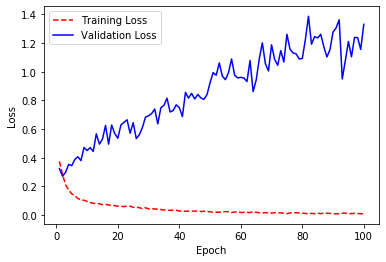

In [18]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
test_lines=create_tokens(test_text)
test_x=encode_text(tokenizer,test_lines,20)
pd.DataFrame(test_x).to_csv("test_file.csv")
scores = model.evaluate(test_x, test_y, verbose=0)
print(scores)

[1.2636536021730793, 0.854477611050677]


In [23]:
yhat=model.predict(test_x,batch_size=100,verbose=1,use_multiprocessing=True)
yhat=(yhat>=0.5).astype(int)
tdf=pd.DataFrame(yhat).rename(columns={0:'Prediction'})
tdf.to_csv("op.csv")
tdf

536/536 [==============================] - 0s 409us/step


Prediction
0             0
1             1
2             0
3             0
4             0
..          ...
531           0
532           0
533           0
534           0
535           0

[536 rows x 1 columns]

In [24]:
i=0
print(test_text[i])
print(yhat[i])
print(test_y[i])

their lies are so thick and many that people do nt see the truth when it is in front of them 
[0]
1


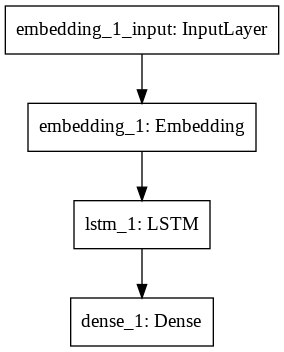

In [25]:
plot_model(model)

In [26]:
m=confusion_matrix(y_pred=yhat, y_true=test_y, labels=[1,0])
nm=confusion_matrix(y_pred=yhat, y_true=test_y, labels=[1,0],normalize='true')
print(m)
print(nm)

[[ 18  40]
 [ 38 440]]
[[0.31034483 0.68965517]
 [0.07949791 0.92050209]]


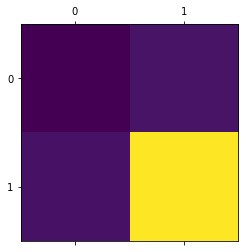

In [27]:
fig=plt.figure().add_subplot()
fig.matshow(m)

In [28]:
print(sklearn.metrics.classification_report(test_y, yhat, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       478
           1       0.32      0.31      0.32        58

    accuracy                           0.85       536
   macro avg       0.62      0.62      0.62       536
weighted avg       0.85      0.85      0.85       536



In [29]:
model.get_weights()

[array([[ 0.02026243,  0.02286838, -0.01881053, ...,  0.04934214,
         -0.02899153,  0.01320428],
        [-0.08262603, -0.02228748, -0.01304559, ...,  0.0574937 ,
         -0.01935873, -0.06926756],
        [-0.03028727,  0.06174108,  0.09682935, ...,  0.02691983,
          0.07188352, -0.02664667],
        ...,
        [-0.01482406,  0.03699291,  0.02792065, ...,  0.04450827,
         -0.0165503 , -0.02915508],
        [-0.03912426, -0.03924625,  0.02451937, ...,  0.03749355,
         -0.00325698,  0.00934682],
        [ 0.00567736, -0.02351205, -0.00065849, ...,  0.02112751,
          0.04965485,  0.03131371]], dtype=float32),
 array([[-0.33786148,  0.05373576,  0.1554566 , ..., -0.068096  ,
         -0.05285557, -0.04583961],
        [ 0.17350054, -0.11502346, -0.04407834, ...,  0.0405067 ,
          0.14906996,  0.26463595],
        [-0.7683658 , -0.5547017 , -0.06167229, ..., -0.1613769 ,
         -1.0409461 , -0.8085513 ],
        ...,
        [-0.08692869, -0.17748861, -0.1